In [209]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from keras.layers import Dense
from sklearn import metrics
from tensorflow.keras import layers
from tensorflow.python.keras.utils import np_utils
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
# multi-class classification with Keras
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# from keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
print(tf.__version__)

2.15.0


In [210]:
# Read in data as pandas dataframe and display first 5 rows
data = pd.read_csv('diabetesmerge.csv')
data.head(100)

,Glucose,BloodPressure,Insulin,Age,Outcome
0,89,66,94,21,0
1,137,40,168,33,2
2,78,50,88,26,0
3,197,70,543,53,2
4,189,60,846,59,2
...,...,...,...,...,...
95,109,64,99,26,1
96,148,60,318,29,2
97,99,70,44,27,0
98,103,72,190,55,1


In [211]:
#One hot encoding
labels = data['Outcome']
# encode class values as integers
encoder = LabelEncoder()
 

In [212]:

encoder.fit(labels)
encoded_Y = encoder.transform(labels)

In [213]:

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_Y)

In [214]:
dummy_y

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [215]:
# Remove the labels from the features
# axis 1 refers to the columns
data= data.drop('Outcome', axis = 1)

# Saving feature names for later use
data_list = list(data.columns)

# Convert to numpy array
data = np.array(data)

In [216]:
data.shape

(728, 4)

In [217]:
dummy_y.shape

(728, 3)

In [218]:
# Split the data into training and testing sets
train_features, val_test_features, train_labels, val_test_labels = train_test_split(data, dummy_y, test_size = 0.3,
                                                                           shuffle=True, random_state = 42)
train_features,train_labels = SMOTE().fit_resample(train_features, train_labels)
X_val, X_test, Y_val, Y_test = train_test_split(val_test_features, val_test_labels, test_size=0.5, shuffle=True, random_state=42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', Y_test.shape)
print('Validation Features Shape:', X_val.shape)
print('Validation Label Shape:', Y_val.shape)

Training Features Shape: (606, 4)
Training Labels Shape: (606, 3)
Testing Features Shape: (110, 4)
Testing Labels Shape: (110, 3)
Validation Features Shape: (109, 4)
Validation Label Shape: (109, 3)


In [219]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

print(normalizer.mean.numpy())

first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

[[116.5924    71.382835  75.02969   32.813534]]
First example: [[147  75   0  28]]

Normalized: [[ 0.99  0.3  -0.72 -0.41]]


In [220]:
class CustomReLU(layers.Layer):
    def __init__(self):
        super(CustomReLU, self).__init__()

    def call(self, inputs):
        return tf.maximum(0.0, inputs)

In [221]:
class MetaAconC(tf.keras.layers.Layer):
    def __init__(self, r=16):
        super(MetaAconC, self).__init__()
        self.fc1 = tf.keras.layers.Dense(r, use_bias=False)
        self.fc2 = tf.keras.layers.Dense(1, use_bias=False)

        self.p1 = tf.Variable(tf.random.normal((1, 1)))
        self.p2 = tf.Variable(tf.random.normal((1, 1)))

        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def call(self, x, **kwargs):
        x_mean = tf.reduce_mean(x, axis=1, keepdims=True)
        beta = self.sigmoid(self.fc2(self.fc1(x_mean)))
        return (self.p1 * x - self.p2 * x) * self.sigmoid(beta * (self.p1 * x - self.p2 * x)) + self.p2 * x

In [222]:
def custom_loss_with_l2(y_true, y_pred):
    l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in model1.trainable_variables if 'kernel' in v.name])
    cross_entropy_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred))
    total_loss = cross_entropy_loss + 0.01 * l2_loss  # 设置L2正则化系数为0.01
    return total_loss

In [223]:
import tensorflow as tf

class Swish(tf.keras.layers.Layer):
    def __init__(self):
        super(Swish, self).__init__()

    def call(self, inputs):
        return tf.keras.activations.swish(inputs)

main model designed

In [224]:
class Atten_model(tf.keras.layers.Layer):
    def __init__(self, in_dim, out_dim):
        super(Atten_model, self).__init__()
        self.k = tf.keras.layers.Dense(in_dim)
        self.q = tf.keras.layers.Dense(in_dim)
        self.v = tf.keras.layers.Dense(in_dim)
        self.proj = tf.keras.layers.Dense(out_dim)
        self.proj_drop = tf.keras.layers.Dropout(0.6)
        self.GELU = MetaAconC()
    def call(self, x):
        # k q v 均将x从in_dim转变为out_dim，特征拓展、特征对应一个权重
        k = self.k(x)
        q = self.q(x)
        v = self.v(x)
        # 点乘计算注意力
        atten = tf.nn.softmax((k * q) / tf.math.sqrt(tf.cast(v.shape[1], dtype=tf.float32)), axis=1)
        # 特征值
        out = self.proj(self.GELU(atten * v))
        return out

In [225]:
#create model_2GDNN
def create_model(data):
  model = keras.Sequential([
      data,
      Atten_model(4, 4),
#       layers.Dense(8),
#       MetaAconC(),
      layers.Dense(8),
      MetaAconC(),
      layers.Dense(16),
#      MetaAconC(),
#       layers.Dense(16),
     MetaAconC(),
      layers.Dense(3, activation="softmax")
  ])
  model.compile(loss=custom_loss_with_l2, optimizer='RMSprop', metrics=['accuracy'])
  return model

In [226]:
normalizer

In [227]:
model1 = create_model(normalizer)

In [228]:
model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, 4)                 9         
 tion)                                                           
                                                                 
 atten_model_11 (Atten_mode  (None, 4)                 114       
 l)                                                              
                                                                 
 dense_167 (Dense)           (None, 8)                 40        
                                                                 
 meta_acon_c_38 (MetaAconC)  (None, 8)                 34        
                                                                 
 dense_170 (Dense)           (None, 16)                144       
                                                                 
 meta_acon_c_39 (MetaAconC)  (None, 16)              

In [229]:
train_features,train_labels

(array([[147,  75,   0,  28],
        [120,  86,   0,  22],
        [103,  72, 152,  27],
        ...,
        [113,  51,  85,  24],
        [103,  66,   0,  29],
        [109,  56, 134,  23]], dtype=int64),
 array([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]]))

In [230]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
mcp_save = ModelCheckpoint('output/bestmodel.tf', save_best_only=True, monitor='val_loss', mode='min')

history=model1.fit(
    train_features, train_labels,
     validation_data=(X_val, Y_val),
    verbose=1,batch_size=32, epochs=200,callbacks=[tensorboard_callback, mcp_save])


Epoch 1/200
16/19 [========================>.....] - ETA: 0s - loss: 1.3223 - accuracy: 0.1426 WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 4s 98ms/step - loss: 1.3200 - accuracy: 0.1601 - val_loss: 1.3057 - val_accuracy: 0.3028
Epoch 2/200
 1/19 [>.............................] - ETA: 0s - loss: 1.3073 - accuracy: 0.2500WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 133ms/step - loss: 1.2961 - accuracy: 0.3449 - val_loss: 1.2850 - val_accuracy: 0.4771
Epoch 3/200
 1/19 [>.............................] - ETA: 0s - loss: 1.2916 - accuracy: 0.3125WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 86ms/step - loss: 1.2760 - accuracy: 0.5132 - val_loss: 1.2639 - val_accuracy: 0.5138
Epoch 4/200
13/19 [===================>..........] - ETA: 0s - loss: 1.2581 - accuracy: 0.5192WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 86ms/step - loss: 1.2542 - accuracy: 0.5132 - val_loss: 1.2381 - val_accuracy: 0.5138
Epoch 5/200
 1/19 [>.............................] - ETA: 0s - loss: 1.2537 - accuracy: 0.4375WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 86ms/step - loss: 1.2264 - accuracy: 0.5380 - val_loss: 1.2045 - val_accuracy: 0.5138
Epoch 6/200
 1/19 [>.............................] - ETA: 0s - loss: 1.1580 - accuracy: 0.5625WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 79ms/step - loss: 1.1926 - accuracy: 0.5330 - val_loss: 1.1681 - val_accuracy: 0.5505
Epoch 7/200
 1/19 [>.............................] - ETA: 0s - loss: 1.1463 - accuracy: 0.5625WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 83ms/step - loss: 1.1515 - accuracy: 0.5726 - val_loss: 1.1290 - val_accuracy: 0.5963
Epoch 8/200
18/19 [===========================>..] - ETA: 0s - loss: 1.1027 - accuracy: 0.6007WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 89ms/step - loss: 1.1029 - accuracy: 0.5974 - val_loss: 1.0897 - val_accuracy: 0.5963
Epoch 9/200
 1/19 [>.............................] - ETA: 0s - loss: 1.1037 - accuracy: 0.5625WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 80ms/step - loss: 1.0479 - accuracy: 0.6040 - val_loss: 1.0495 - val_accuracy: 0.5872
Epoch 10/200
15/19 [======================>.......] - ETA: 0s - loss: 0.9930 - accuracy: 0.6229WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 90ms/step - loss: 0.9893 - accuracy: 0.6205 - val_loss: 1.0090 - val_accuracy: 0.5872
Epoch 11/200
19/19 [==============================] - ETA: 0s - loss: 0.9353 - accuracy: 0.6403WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 84ms/step - loss: 0.9353 - accuracy: 0.6403 - val_loss: 0.9635 - val_accuracy: 0.5963
Epoch 12/200
 1/19 [>.............................] - ETA: 0s - loss: 0.9276 - accuracy: 0.5938WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 82ms/step - loss: 0.8861 - accuracy: 0.6650 - val_loss: 0.9177 - val_accuracy: 0.6422
Epoch 13/200
 1/19 [>.............................] - ETA: 0s - loss: 0.9247 - accuracy: 0.6562WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 90ms/step - loss: 0.8429 - accuracy: 0.6749 - val_loss: 0.8718 - val_accuracy: 0.6972
Epoch 14/200
 1/19 [>.............................] - ETA: 0s - loss: 0.7414 - accuracy: 0.8125WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 138ms/step - loss: 0.8064 - accuracy: 0.7079 - val_loss: 0.8291 - val_accuracy: 0.7064
Epoch 15/200
 1/19 [>.............................] - ETA: 0s - loss: 0.9910 - accuracy: 0.6875WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 81ms/step - loss: 0.7724 - accuracy: 0.7310 - val_loss: 0.7852 - val_accuracy: 0.7156
Epoch 16/200
 1/19 [>.............................] - ETA: 0s - loss: 0.8076 - accuracy: 0.6875WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 84ms/step - loss: 0.7386 - accuracy: 0.7624 - val_loss: 0.7419 - val_accuracy: 0.7339
Epoch 17/200
17/19 [=========================>....] - ETA: 0s - loss: 0.7088 - accuracy: 0.7849WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 85ms/step - loss: 0.7064 - accuracy: 0.7822 - val_loss: 0.6996 - val_accuracy: 0.7339
Epoch 18/200
 1/19 [>.............................] - ETA: 0s - loss: 0.7010 - accuracy: 0.7500WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 90ms/step - loss: 0.6761 - accuracy: 0.8168 - val_loss: 0.6575 - val_accuracy: 0.7982
Epoch 19/200
 1/19 [>.............................] - ETA: 0s - loss: 0.5598 - accuracy: 0.8750WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 89ms/step - loss: 0.6472 - accuracy: 0.8366 - val_loss: 0.6212 - val_accuracy: 0.8257
Epoch 20/200
 1/19 [>.............................] - ETA: 0s - loss: 0.6939 - accuracy: 0.8750WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 84ms/step - loss: 0.6223 - accuracy: 0.8515 - val_loss: 0.5867 - val_accuracy: 0.8349
Epoch 21/200
 1/19 [>.............................] - ETA: 0s - loss: 0.4958 - accuracy: 0.8750WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 79ms/step - loss: 0.5982 - accuracy: 0.8597 - val_loss: 0.5526 - val_accuracy: 0.8624
Epoch 22/200
 1/19 [>.............................] - ETA: 0s - loss: 0.4617 - accuracy: 0.9375WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 84ms/step - loss: 0.5775 - accuracy: 0.8746 - val_loss: 0.5245 - val_accuracy: 0.8991
Epoch 23/200
 1/19 [>.............................] - ETA: 0s - loss: 0.4664 - accuracy: 0.9375WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 83ms/step - loss: 0.5570 - accuracy: 0.8927 - val_loss: 0.4997 - val_accuracy: 0.8991
Epoch 24/200
 1/19 [>.............................] - ETA: 0s - loss: 0.4733 - accuracy: 0.9062WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 85ms/step - loss: 0.5382 - accuracy: 0.9026 - val_loss: 0.4733 - val_accuracy: 0.9174
Epoch 25/200
12/19 [=================>............] - ETA: 0s - loss: 0.5402 - accuracy: 0.9141WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 94ms/step - loss: 0.5201 - accuracy: 0.9158 - val_loss: 0.4532 - val_accuracy: 0.9358
Epoch 26/200
 1/19 [>.............................] - ETA: 0s - loss: 0.4812 - accuracy: 0.9062WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 137ms/step - loss: 0.5008 - accuracy: 0.9208 - val_loss: 0.4350 - val_accuracy: 0.9358
Epoch 27/200
18/19 [===========================>..] - ETA: 0s - loss: 0.4793 - accuracy: 0.9184WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 89ms/step - loss: 0.4838 - accuracy: 0.9175 - val_loss: 0.4181 - val_accuracy: 0.9358
Epoch 28/200
 1/19 [>.............................] - ETA: 0s - loss: 0.3801 - accuracy: 0.9375WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 81ms/step - loss: 0.4665 - accuracy: 0.9290 - val_loss: 0.4005 - val_accuracy: 0.9450
Epoch 29/200
 1/19 [>.............................] - ETA: 0s - loss: 0.5237 - accuracy: 0.9375WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 84ms/step - loss: 0.4521 - accuracy: 0.9340 - val_loss: 0.3882 - val_accuracy: 0.9450
Epoch 30/200
 1/19 [>.............................] - ETA: 0s - loss: 0.4427 - accuracy: 0.8750WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 85ms/step - loss: 0.4367 - accuracy: 0.9389 - val_loss: 0.3739 - val_accuracy: 0.9450
Epoch 31/200
 1/19 [>.............................] - ETA: 0s - loss: 0.4652 - accuracy: 0.9688WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 86ms/step - loss: 0.4221 - accuracy: 0.9439 - val_loss: 0.3662 - val_accuracy: 0.9633
Epoch 32/200
16/19 [========================>.....] - ETA: 0s - loss: 0.4214 - accuracy: 0.9492WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 84ms/step - loss: 0.4076 - accuracy: 0.9505 - val_loss: 0.3505 - val_accuracy: 0.9633
Epoch 33/200
15/19 [======================>.......] - ETA: 0s - loss: 0.3992 - accuracy: 0.9542WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 86ms/step - loss: 0.3972 - accuracy: 0.9538 - val_loss: 0.3433 - val_accuracy: 0.9633
Epoch 34/200
19/19 [==============================] - 0s 4ms/step - loss: 0.3835 - accuracy: 0.9521 - val_loss: 0.3440 - val_accuracy: 0.9633
Epoch 35/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2883 - accuracy: 0.9375WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 81ms/step - loss: 0.3773 - accuracy: 0.9538 - val_loss: 0.3287 - val_accuracy: 0.9725
Epoch 36/200
 1/19 [>.............................] - ETA: 0s - loss: 0.5017 - accuracy: 0.9062WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 84ms/step - loss: 0.3668 - accuracy: 0.9587 - val_loss: 0.3218 - val_accuracy: 0.9725
Epoch 37/200
18/19 [===========================>..] - ETA: 0s - loss: 0.3618 - accuracy: 0.9635WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 87ms/step - loss: 0.3580 - accuracy: 0.9653 - val_loss: 0.3145 - val_accuracy: 0.9725
Epoch 38/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2706 - accuracy: 1.0000WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 78ms/step - loss: 0.3522 - accuracy: 0.9637 - val_loss: 0.3116 - val_accuracy: 0.9817
Epoch 39/200
 1/19 [>.............................] - ETA: 0s - loss: 0.3049 - accuracy: 0.9688WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 82ms/step - loss: 0.3451 - accuracy: 0.9686 - val_loss: 0.3035 - val_accuracy: 0.9817
Epoch 40/200
19/19 [==============================] - ETA: 0s - loss: 0.3361 - accuracy: 0.9703WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 129ms/step - loss: 0.3361 - accuracy: 0.9703 - val_loss: 0.2997 - val_accuracy: 0.9817
Epoch 41/200
19/19 [==============================] - 0s 5ms/step - loss: 0.3324 - accuracy: 0.9703 - val_loss: 0.3023 - val_accuracy: 0.9817
Epoch 42/200
 1/19 [>.............................] - ETA: 0s - loss: 0.4886 - accuracy: 0.9062WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 83ms/step - loss: 0.3263 - accuracy: 0.9686 - val_loss: 0.2947 - val_accuracy: 0.9817
Epoch 43/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2829 - accuracy: 1.0000WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 79ms/step - loss: 0.3210 - accuracy: 0.9752 - val_loss: 0.2936 - val_accuracy: 0.9817
Epoch 44/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2684 - accuracy: 1.0000WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 85ms/step - loss: 0.3146 - accuracy: 0.9736 - val_loss: 0.2849 - val_accuracy: 0.9817
Epoch 45/200
 1/19 [>.............................] - ETA: 0s - loss: 0.3101 - accuracy: 0.9688WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 92ms/step - loss: 0.3089 - accuracy: 0.9736 - val_loss: 0.2790 - val_accuracy: 0.9725
Epoch 46/200
19/19 [==============================] - 0s 5ms/step - loss: 0.3053 - accuracy: 0.9769 - val_loss: 0.2824 - val_accuracy: 0.9817
Epoch 47/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2458 - accuracy: 1.0000WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 81ms/step - loss: 0.3012 - accuracy: 0.9752 - val_loss: 0.2770 - val_accuracy: 0.9725
Epoch 48/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2584 - accuracy: 1.0000WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 87ms/step - loss: 0.2952 - accuracy: 0.9736 - val_loss: 0.2723 - val_accuracy: 0.9817
Epoch 49/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2553 - accuracy: 1.0000WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 84ms/step - loss: 0.2918 - accuracy: 0.9752 - val_loss: 0.2699 - val_accuracy: 0.9817
Epoch 50/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2538 - accuracy: 1.0000WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 80ms/step - loss: 0.2867 - accuracy: 0.9769 - val_loss: 0.2604 - val_accuracy: 0.9817
Epoch 51/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2886 - accuracy: 0.9688WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 84ms/step - loss: 0.2824 - accuracy: 0.9785 - val_loss: 0.2593 - val_accuracy: 0.9817
Epoch 52/200
19/19 [==============================] - 0s 7ms/step - loss: 0.2788 - accuracy: 0.9785 - val_loss: 0.2611 - val_accuracy: 0.9725
Epoch 53/200
14/19 [=====================>........] - ETA: 0s - loss: 0.2838 - accuracy: 0.9754WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 82ms/step - loss: 0.2744 - accuracy: 0.9785 - val_loss: 0.2567 - val_accuracy: 0.9817
Epoch 54/200
19/19 [==============================] - 0s 5ms/step - loss: 0.2703 - accuracy: 0.9785 - val_loss: 0.2574 - val_accuracy: 0.9817
Epoch 55/200
19/19 [==============================] - 0s 6ms/step - loss: 0.2682 - accuracy: 0.9752 - val_loss: 0.2568 - val_accuracy: 0.9908
Epoch 56/200
19/19 [==============================] - 0s 5ms/step - loss: 0.2633 - accuracy: 0.9752 - val_loss: 0.2588 - val_accuracy: 0.9817
Epoch 57/200
 1/19 [>.............................] - ETA: 0s - loss: 0.3362 - accuracy: 0.9375WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 87ms/step - loss: 0.2614 - accuracy: 0.9752 - val_loss: 0.2443 - val_accuracy: 0.9908
Epoch 58/200
19/19 [==============================] - 0s 6ms/step - loss: 0.2572 - accuracy: 0.9785 - val_loss: 0.2460 - val_accuracy: 0.9908
Epoch 59/200
19/19 [==============================] - 0s 6ms/step - loss: 0.2530 - accuracy: 0.9802 - val_loss: 0.2519 - val_accuracy: 0.9633
Epoch 60/200
19/19 [==============================] - 0s 6ms/step - loss: 0.2525 - accuracy: 0.9802 - val_loss: 0.2454 - val_accuracy: 0.9817
Epoch 61/200
19/19 [==============================] - 0s 5ms/step - loss: 0.2485 - accuracy: 0.9835 - val_loss: 0.2451 - val_accuracy: 0.9817
Epoch 62/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2837 - accuracy: 0.9688WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 132ms/step - loss: 0.2483 - accuracy: 0.9785 - val_loss: 0.2427 - val_accuracy: 0.9908
Epoch 63/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2422 - accuracy: 1.0000WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 85ms/step - loss: 0.2440 - accuracy: 0.9769 - val_loss: 0.2313 - val_accuracy: 0.9908
Epoch 64/200
19/19 [==============================] - 0s 4ms/step - loss: 0.2421 - accuracy: 0.9851 - val_loss: 0.2349 - val_accuracy: 0.9908
Epoch 65/200
19/19 [==============================] - 0s 5ms/step - loss: 0.2404 - accuracy: 0.9851 - val_loss: 0.2324 - val_accuracy: 0.9908
Epoch 66/200
19/19 [==============================] - 0s 5ms/step - loss: 0.2384 - accuracy: 0.9835 - val_loss: 0.2381 - val_accuracy: 0.9817
Epoch 67/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2232 - accuracy: 1.0000WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 83ms/step - loss: 0.2374 - accuracy: 0.9868 - val_loss: 0.2272 - val_accuracy: 0.9908
Epoch 68/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2427 - accuracy: 1.0000WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 79ms/step - loss: 0.2328 - accuracy: 0.9851 - val_loss: 0.2256 - val_accuracy: 0.9908
Epoch 69/200
18/19 [===========================>..] - ETA: 0s - loss: 0.2331 - accuracy: 0.9809WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 87ms/step - loss: 0.2320 - accuracy: 0.9818 - val_loss: 0.2225 - val_accuracy: 0.9725
Epoch 70/200
19/19 [==============================] - 0s 4ms/step - loss: 0.2315 - accuracy: 0.9835 - val_loss: 0.2242 - val_accuracy: 0.9817
Epoch 71/200
19/19 [==============================] - 0s 4ms/step - loss: 0.2281 - accuracy: 0.9868 - val_loss: 0.2254 - val_accuracy: 0.9908
Epoch 72/200
19/19 [==============================] - 0s 5ms/step - loss: 0.2266 - accuracy: 0.9901 - val_loss: 0.2293 - val_accuracy: 0.9817
Epoch 73/200
18/19 [===========================>..] - ETA: 0s - loss: 0.2272 - accuracy: 0.9861WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 88ms/step - loss: 0.2249 - accuracy: 0.9868 - val_loss: 0.2216 - val_accuracy: 0.9817
Epoch 74/200
19/19 [==============================] - 0s 5ms/step - loss: 0.2237 - accuracy: 0.9818 - val_loss: 0.2231 - val_accuracy: 0.9908
Epoch 75/200
19/19 [==============================] - 0s 4ms/step - loss: 0.2221 - accuracy: 0.9884 - val_loss: 0.2223 - val_accuracy: 0.9817
Epoch 76/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2064 - accuracy: 1.0000WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 78ms/step - loss: 0.2221 - accuracy: 0.9818 - val_loss: 0.2194 - val_accuracy: 0.9908
Epoch 77/200
19/19 [==============================] - 0s 6ms/step - loss: 0.2182 - accuracy: 0.9835 - val_loss: 0.2277 - val_accuracy: 0.9817
Epoch 78/200
19/19 [==============================] - 0s 4ms/step - loss: 0.2173 - accuracy: 0.9884 - val_loss: 0.2266 - val_accuracy: 0.9817
Epoch 79/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2206 - accuracy: 1.0000WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 82ms/step - loss: 0.2167 - accuracy: 0.9818 - val_loss: 0.2118 - val_accuracy: 0.9908
Epoch 80/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2189 - accuracy: 0.9688WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 83ms/step - loss: 0.2137 - accuracy: 0.9851 - val_loss: 0.2108 - val_accuracy: 0.9725
Epoch 81/200
19/19 [==============================] - 0s 4ms/step - loss: 0.2148 - accuracy: 0.9851 - val_loss: 0.2190 - val_accuracy: 0.9908
Epoch 82/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2265 - accuracy: 1.0000WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 79ms/step - loss: 0.2115 - accuracy: 0.9884 - val_loss: 0.2036 - val_accuracy: 1.0000
Epoch 83/200
19/19 [==============================] - 0s 4ms/step - loss: 0.2124 - accuracy: 0.9818 - val_loss: 0.2082 - val_accuracy: 0.9908
Epoch 84/200
19/19 [==============================] - 0s 4ms/step - loss: 0.2088 - accuracy: 0.9868 - val_loss: 0.2212 - val_accuracy: 0.9908
Epoch 85/200
19/19 [==============================] - 0s 4ms/step - loss: 0.2092 - accuracy: 0.9884 - val_loss: 0.2210 - val_accuracy: 0.9633
Epoch 86/200
19/19 [==============================] - 0s 4ms/step - loss: 0.2096 - accuracy: 0.9802 - val_loss: 0.2093 - val_accuracy: 0.9908
Epoch 87/200
19/19 [==============================] - 0s 4ms/step - loss: 0.2046 - accuracy: 0.9884 - val_loss: 0.2067 - val_accuracy: 0.9817
Epoch 88/200
 1/19 [>.............................] - ETA: 0s - loss: 0.1673 - accuracy: 1.0000WARNING:tensorflow:Skipping full serialization of Keras layer <ke

INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 82ms/step - loss: 0.2060 - accuracy: 0.9802 - val_loss: 0.2006 - val_accuracy: 0.9908
Epoch 89/200
19/19 [==============================] - 0s 4ms/step - loss: 0.2052 - accuracy: 0.9868 - val_loss: 0.2039 - val_accuracy: 0.9908
Epoch 90/200
19/19 [==============================] - 0s 5ms/step - loss: 0.2038 - accuracy: 0.9884 - val_loss: 0.2172 - val_accuracy: 0.9908
Epoch 91/200
19/19 [==============================] - 0s 4ms/step - loss: 0.2016 - accuracy: 0.9868 - val_loss: 0.2034 - val_accuracy: 0.9908
Epoch 92/200
19/19 [==============================] - 0s 4ms/step - loss: 0.2007 - accuracy: 0.9884 - val_loss: 0.2157 - val_accuracy: 0.9908
Epoch 93/200
19/19 [==============================] - 0s 5ms/step - loss: 0.2002 - accuracy: 0.9917 - val_loss: 0.2030 - val_accuracy: 0.9817
Epoch 94/200
 1/19 [>.............................] - ETA: 0s - loss: 0.1773 - accuracy: 1.0000WARNING:tensorflow:Skipping full serialization of Keras layer <ke

INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 82ms/step - loss: 0.1982 - accuracy: 0.9884 - val_loss: 0.1971 - val_accuracy: 1.0000
Epoch 95/200
19/19 [==============================] - 0s 5ms/step - loss: 0.1989 - accuracy: 0.9884 - val_loss: 0.2085 - val_accuracy: 0.9817
Epoch 96/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1958 - accuracy: 0.9901 - val_loss: 0.1988 - val_accuracy: 0.9908
Epoch 97/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2154 - accuracy: 0.9688WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 78ms/step - loss: 0.1965 - accuracy: 0.9884 - val_loss: 0.1929 - val_accuracy: 1.0000
Epoch 98/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1954 - accuracy: 0.9884 - val_loss: 0.2082 - val_accuracy: 0.9725
Epoch 99/200
 1/19 [>.............................] - ETA: 0s - loss: 0.2046 - accuracy: 0.9688WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 130ms/step - loss: 0.1944 - accuracy: 0.9868 - val_loss: 0.1873 - val_accuracy: 1.0000
Epoch 100/200
19/19 [==============================] - 0s 5ms/step - loss: 0.1949 - accuracy: 0.9851 - val_loss: 0.2020 - val_accuracy: 0.9908
Epoch 101/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1930 - accuracy: 0.9884 - val_loss: 0.2059 - val_accuracy: 0.9908
Epoch 102/200
19/19 [==============================] - 0s 5ms/step - loss: 0.1930 - accuracy: 0.9868 - val_loss: 0.1909 - val_accuracy: 0.9908
Epoch 103/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1906 - accuracy: 0.9901 - val_loss: 0.2116 - val_accuracy: 0.9817
Epoch 104/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1903 - accuracy: 0.9884 - val_loss: 0.2081 - val_accuracy: 0.9908
Epoch 105/200
19/19 [==============================] - 0s 5ms/step - loss: 0.1914 - accuracy: 0.9851 - val_loss: 0.2094 - val_accuracy: 0.9633
Epoch 106/2

INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 79ms/step - loss: 0.1819 - accuracy: 0.9868 - val_loss: 0.1811 - val_accuracy: 0.9908
Epoch 119/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1794 - accuracy: 0.9934 - val_loss: 0.1922 - val_accuracy: 0.9817
Epoch 120/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1808 - accuracy: 0.9868 - val_loss: 0.1921 - val_accuracy: 0.9908
Epoch 121/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1800 - accuracy: 0.9868 - val_loss: 0.1856 - val_accuracy: 0.9817
Epoch 122/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1784 - accuracy: 0.9884 - val_loss: 0.1868 - val_accuracy: 0.9817
Epoch 123/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1775 - accuracy: 0.9934 - val_loss: 0.1857 - val_accuracy: 0.9817
Epoch 124/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1763 - accuracy: 0.9901 - val_loss: 0.2117 - val_accuracy: 0.9541
Epoch 125/20

INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 78ms/step - loss: 0.1760 - accuracy: 0.9884 - val_loss: 0.1763 - val_accuracy: 0.9908
Epoch 132/200
 1/19 [>.............................] - ETA: 0s - loss: 0.1725 - accuracy: 0.9688WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 83ms/step - loss: 0.1706 - accuracy: 0.9950 - val_loss: 0.1710 - val_accuracy: 0.9817
Epoch 133/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1744 - accuracy: 0.9868 - val_loss: 0.1876 - val_accuracy: 0.9817
Epoch 134/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1731 - accuracy: 0.9868 - val_loss: 0.1816 - val_accuracy: 0.9817
Epoch 135/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1725 - accuracy: 0.9868 - val_loss: 0.1793 - val_accuracy: 0.9908
Epoch 136/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1724 - accuracy: 0.9917 - val_loss: 0.1908 - val_accuracy: 0.9725
Epoch 137/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1723 - accuracy: 0.9917 - val_loss: 0.1783 - val_accuracy: 0.9817
Epoch 138/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1694 - accuracy: 0.9868 - val_loss: 0.1838 - val_accuracy: 0.9725
Epoch 139/20

INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 1s 82ms/step - loss: 0.1619 - accuracy: 0.9950 - val_loss: 0.1682 - val_accuracy: 0.9817
Epoch 161/200
19/19 [==============================] - 0s 5ms/step - loss: 0.1620 - accuracy: 0.9901 - val_loss: 0.1862 - val_accuracy: 0.9725
Epoch 162/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1603 - accuracy: 0.9917 - val_loss: 0.1907 - val_accuracy: 0.9817
Epoch 163/200
19/19 [==============================] - 0s 6ms/step - loss: 0.1617 - accuracy: 0.9917 - val_loss: 0.1999 - val_accuracy: 0.9817
Epoch 164/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1599 - accuracy: 0.9901 - val_loss: 0.1799 - val_accuracy: 0.9817
Epoch 165/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1598 - accuracy: 0.9901 - val_loss: 0.1881 - val_accuracy: 0.9817
Epoch 166/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1561 - accuracy: 0.9917 - val_loss: 0.1806 - val_accuracy: 0.9633
Epoch 167/20

INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 82ms/step - loss: 0.1587 - accuracy: 0.9884 - val_loss: 0.1623 - val_accuracy: 0.9817
Epoch 168/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1590 - accuracy: 0.9884 - val_loss: 0.1961 - val_accuracy: 0.9725
Epoch 169/200
19/19 [==============================] - 0s 5ms/step - loss: 0.1602 - accuracy: 0.9884 - val_loss: 0.1838 - val_accuracy: 0.9817
Epoch 170/200
19/19 [==============================] - 0s 5ms/step - loss: 0.1564 - accuracy: 0.9950 - val_loss: 0.1701 - val_accuracy: 0.9817
Epoch 171/200
19/19 [==============================] - 0s 5ms/step - loss: 0.1582 - accuracy: 0.9901 - val_loss: 0.1746 - val_accuracy: 0.9817
Epoch 172/200
19/19 [==============================] - 0s 6ms/step - loss: 0.1573 - accuracy: 0.9917 - val_loss: 0.1776 - val_accuracy: 0.9817
Epoch 173/200
19/19 [==============================] - 0s 5ms/step - loss: 0.1588 - accuracy: 0.9884 - val_loss: 0.1819 - val_accuracy: 0.9817
Epoch 174/20

INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 83ms/step - loss: 0.1505 - accuracy: 0.9884 - val_loss: 0.1582 - val_accuracy: 0.9725
Epoch 195/200
19/19 [==============================] - 0s 5ms/step - loss: 0.1529 - accuracy: 0.9901 - val_loss: 0.1648 - val_accuracy: 0.9817
Epoch 196/200
 1/19 [>.............................] - ETA: 0s - loss: 0.1518 - accuracy: 1.0000WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x0000018873F69610>, because it is not built.


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


INFO:tensorflow:Assets written to: output\bestmodel.tf\assets


19/19 [==============================] - 2s 90ms/step - loss: 0.1501 - accuracy: 0.9917 - val_loss: 0.1564 - val_accuracy: 0.9908
Epoch 197/200
19/19 [==============================] - 0s 5ms/step - loss: 0.1482 - accuracy: 0.9917 - val_loss: 0.2018 - val_accuracy: 0.9725
Epoch 198/200
19/19 [==============================] - 0s 5ms/step - loss: 0.1496 - accuracy: 0.9901 - val_loss: 0.1699 - val_accuracy: 0.9817
Epoch 199/200
19/19 [==============================] - 0s 5ms/step - loss: 0.1490 - accuracy: 0.9917 - val_loss: 0.1571 - val_accuracy: 0.9908
Epoch 200/200
19/19 [==============================] - 0s 5ms/step - loss: 0.1487 - accuracy: 0.9901 - val_loss: 0.1596 - val_accuracy: 0.9817


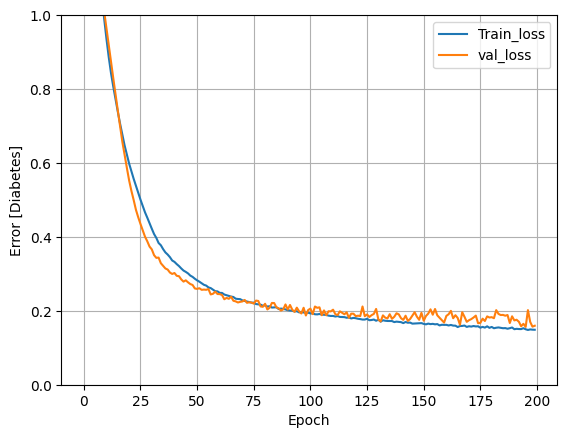

In [231]:
#plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='Train_loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Diabetes]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

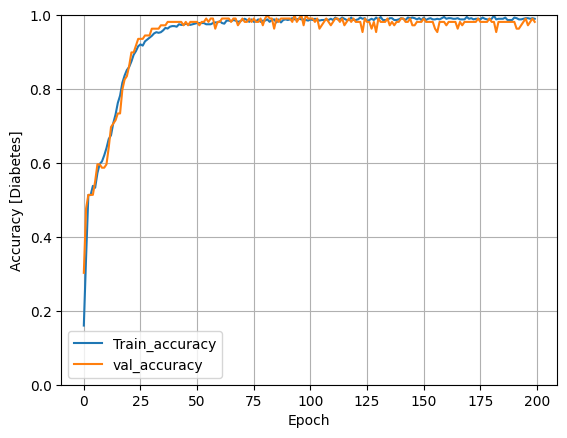

In [232]:
#plot accuracy
def plot_loss(history):
  plt.plot(history.history['accuracy'], label='Train_accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy [Diabetes]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [233]:
#Save model
# #model1.save('DLmodelm.tf')
# model_loaded = tf.keras.models.load_model('output/bestmodel.tf')


In [246]:
#Evaluation
# Prediction
prediction = np.around(model1.predict(X_test))
print(metrics.classification_report(Y_test,prediction, digits=8))

4/4 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0  1.00000000 0.95833333 0.97872340        24
           1  0.97222222 0.94594595 0.95890411        37
           2  0.96078431 1.00000000 0.98000000        49

   micro avg  0.97272727 0.97272727 0.97272727       110
   macro avg  0.97766885 0.96809309 0.97254250       110
weighted avg  0.97318776 0.97272727 0.97262558       110
 samples avg  0.97272727 0.97272727 0.97272727       110



In [247]:
# Use the forest's predict method on the test data
predictions = model1.predict(X_test)

# Calculate mean absolute errors
score = model1.evaluate(X_test, Y_test,verbose=1)

4/4 [==============================] - 0s 3ms/step - loss: 0.2301 - accuracy: 0.9727


In [248]:
# Compare Prediction 
print("Train acc: " , model1.evaluate(train_features, train_labels))
print("Test acc: ", model1.evaluate(X_test, Y_test))

19/19 [==============================] - 0s 2ms/step - loss: 0.1438 - accuracy: 0.9983
Train acc:  [0.1438218653202057, 0.9983498454093933]
4/4 [==============================] - 0s 6ms/step - loss: 0.2301 - accuracy: 0.9727
Test acc:  [0.23011770844459534, 0.9727272987365723]


In [249]:
y = np.reshape(prediction,(110,3))
p  = np.argmax(y,axis=1)
Y=np.argmax(Y_test, axis=1)

In [250]:
# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
confusion = metrics.confusion_matrix(Y, p)
print(confusion)

[[23  1  0]
 [ 0 35  2]
 [ 0  0 49]]


In [251]:
new_df = pd.DataFrame([[80, 75, 232, 45]])
# We predict insulin
prediction = model1.predict(new_df)
prediction

1/1 [==============================] - 0s 26ms/step


array([[9.9625790e-01, 5.2441794e-11, 3.7420965e-03]], dtype=float32)

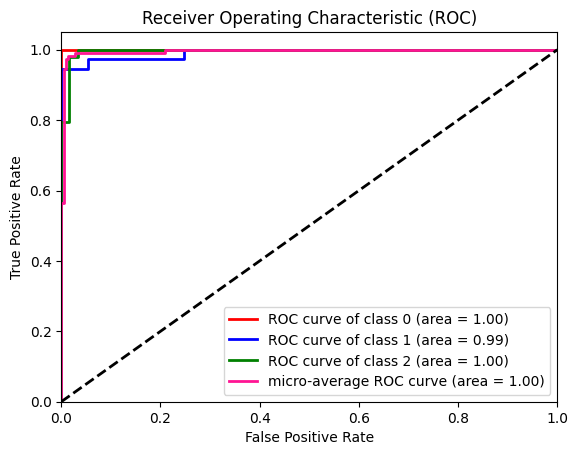

In [252]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# 假设预测概率保存在y_scores变量中，真实标签保存在y_true变量中
y_scores = predictions
y_true = y_true

# 将多分类问题转化为二分类问题
n_classes = 3
y_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算微平均ROC曲线和AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 绘制每个类别的ROC曲线
plt.figure()
colors = ['red', 'blue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# 绘制微平均ROC曲线
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2,
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [253]:
#Calculate metrics
y_true = Y
y_prediction = p
cnf_matrix = confusion_matrix(y_true, y_prediction)

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [254]:
#Performance evaluation metrics
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [255]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 13436), started 2 days, 1:07:10 ago. (Use '!kill 13436' to kill it.)

In [244]:
!tensorboard dev upload \
  --logdir logs \
  --name "Sample op-level graph" \
  --one_shot

2023-12-23 16:09:51.808474: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorboard.dev/ is no longer
supported.

TensorBoard.dev is shutting down.

Please export your experiments by Dec 31, 2023.

See the FAQ at https://tensorboard.dev.

****************************************************************
****************************************************************
****************************************************************


In [ ]:
data